### FedAvg


In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Client:
    """
    Client class for the federated learning process

    Args:
        id (int): Client id
        data (DataLoader): Data loader
        model (nn.Module): Model
        lr (float): Learning rate
        weight_decay (float): Weight decay
        device (str): Device
    """

    def __init__(self, id, data, model, lr=0.01, device=device):
        self.id = id
        self.data = data
        self.model = model.to(device)
        self.device = device
        self.R = torch.zeros(30)
        self.optimizer = optim.SGD(
            self.model.parameters(), lr=lr
        )
        self.loss_func = nn.MSELoss()

    # def train(self, num_epochs, params, progress_bar):
    #     """
    #     Train the model for a number of epochs

    #     Args:
    #         num_epochs (int): Number of epochs
    #         params (dict): Model parameters
    #         progress_bar (tqdm): Progress bar

    #         Returns:
    #             float: Loss
    #     """
    #     self.model.load_state_dict(params)
    #     self.model.train()
    #     for epoch in range(num_epochs):
    #         running_loss = 0.0
    #         for batch_idx, (x, y) in enumerate(self.data):
    #             x, y = x.to(self.device), y.to(self.device)
    #             self.optimizer.zero_grad()
    #             y_pred = self.model(x)
    #             loss = self.loss_func(y_pred, y)
    #             loss.backward()
    #             self.optimizer.step()
    #             running_loss += loss.item()
    #         progress_bar.update(1)
    #     progress_bar.set_postfix({"loss": running_loss / len(self.data)})
    #     return running_loss / len(self.data)

    def compute_w(self, lambd):
        X = []
        y = []

        for batch_idx, (x, y_) in enumerate(self.data):
            x, y_ = x.to(self.device), y_.to(self.device)
            X.append(x)
            y.append(y_)

        # Concatenate the lists into single tensors
        X = torch.cat(X, dim=0)  # Shape: (n_samples, n_features)
        y = torch.cat(y, dim=0)  # Shape: (n_samples, 1)

        n_samples = X.size(0)

        sigma = torch.zeros(X.size(1), device=self.device)  # Number of features
        alpha = torch.zeros(X.size(1), device=self.device)

        for j in range(X.size(1)):
            X_j = X[:, j]  # Extract the j-th predictor column from X
            sigma[j] = torch.mean(X_j ** 2)
            alpha[j] = torch.mean(X_j * y)

        # Calculate weights
        w = (torch.sign(alpha) / sigma) * torch.maximum(torch.zeros_like(alpha), torch.abs(alpha) - lambd)

        # Reshape w to match the expected shape of the model's parameters
        w = w.view(1, -1)  # Reshape to (1, 30)

        # Create a state dict for the model
        state_dict = {
            'linear.weight': w,  # Reshape w to (1, 30)
            # If your model has a bias, you should include it as well
            # 'linear.bias': some_bias_tensor,  # Add this line if you have a bias
        }

        self.set_params(state_dict)

        self.R = torch.where(w != 0, torch.tensor(1.0, device=self.device), torch.tensor(0.0, device=self.device))

    def get_params(self):
        return self.model.state_dict()

    def set_params(self, params):
        self.model.load_state_dict(params)

In [ ]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score

class Server:
    """
    Server class for the federated learning process

    Args:
        clients (list): List of clients
        model (nn.Module): Model

    """

    def __init__(self, clients, model):
        self.clients = clients
        self.model = model
        self.loss_func = nn.MSELoss()

    # def aggregate(self, sample_clients):
    #     """
    #     Aggregate the model parameters from the clients

    #     Args:
    #         None

    #     Returns:
    #         None
    #     """
    #     params = [client.get_params() for client in sample_clients]
    #     # simple averaging of the clients model parameters
    #     avg_params = {}
    #     for key in params[0].keys():
    #         avg_params[key] = torch.stack(
    #             [params[i][key] for i in range(len(params))], 0
    #         ).mean(0)
    #     self.model.load_state_dict(avg_params)

    def test(self, data):
        """
        Test the model

        Args:
            data (DataLoader): Data loader

        Returns:
            float: Loss (MSE)
        """
        self.model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for batch_idx, (x, y) in enumerate(data):
                y_pred = self.model(x)
                loss = self.loss_func(y_pred, y)
                test_loss += loss.item()
        return test_loss / len(data)

    def aggregate_supports(self, sample_clients):
        R_aggregates = torch.zeros(30, device=sample_clients[0].device)
        w_aggregates = None  # Initialize as None to handle first client separately

        for client in sample_clients:
            R_aggregates += client.R.view(-1)  # Ensure client.R is a 1D tensor
            client_params = client.get_params()

            # Initialize w_aggregates with the correct shape using the first client's weights
            if w_aggregates is None:
                # Assuming 'linear.weight' is the correct key for weights
                w_aggregates = client_params['linear.weight'].clone()  # Start with the first client's weights
            else:
                w_aggregates += client_params['linear.weight']

        # Average the R values
        R_aggregates /= len(sample_clients)
        w_aggregates /= len(sample_clients)

        name = ['mean radius', 'mean texture', 'mean perimeter', 'mean area',
        'mean smoothness', 'mean compactness', 'mean concavity',
        'mean concave points', 'mean symmetry', 'mean fractal dimension',
        'radius error', 'texture error', 'perimeter error', 'area error',
        'smoothness error', 'compactness error', 'concavity error',
        'concave points error', 'symmetry error', 'fractal dimension error',
        'worst radius', 'worst texture', 'worst perimeter', 'worst area',
        'worst smoothness', 'worst compactness', 'worst concavity',
        'worst concave points', 'worst symmetry', 'worst fractal dimension']
        global_predictors = []

        for idx, value in enumerate(R_aggregates):
            if value >= 0.5:
                global_predictors.append(name[idx])
            else:
                w_aggregates[0, idx] = 0  # If not a global predictor, set weight to zero

        # Create a state dict for the model
        state_dict = {
            'linear.weight': w_aggregates,  # Ensure correct shape
            # Add 'linear.bias': ... if you have a bias term in your model
        }

        self.model.load_state_dict(state_dict)
        print(len(global_predictors))
        print(global_predictors)

    def get_params(self):
        return self.model.state_dict()

    def set_params(self, params):
        self.model.load_state_dict(params)

In [ ]:
from torch import nn
import torch.nn.functional as F
import torch


class LinearRegressionModel(nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(30, 1, bias=False)  # Linear layer with one output

    def forward(self, x):
        return self.linear(x)

In [ ]:
from ast import Dict
from unittest import result
from matplotlib.pyplot import cla
import matplotlib.pyplot as plt
from sympy import ordered
import torch
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Subset

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import plotly.graph_objects as go
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split, SubsetRandomSampler

import seaborn as sns
import tqdm
import joblib
import numpy as np
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset, random_split, SubsetRandomSampler
import matplotlib.pyplot as plt
import tqdm
import joblib

def fedSgdPar(
    model=LinearRegressionModel(),
    T=1,
    K=10,
    C=1,
    E=1,
    lambd=1,
    noiid=False
):
    """
    Run the parallel implementation of FedSGD on the Diabetes dataset using the entire dataset.

    Args:
        model (nn.Module): Model
        T (int): Number of rounds
        K (int): Number of clients
        C (int): Fraction of clients to be sampled per round
        E (int): Number of local epochs
        lr (float): Learning rate of the client optimizer

    Returns:
    (dict): Test loss and feature selection results
    """

    # Set the random seed
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)

    # clients_each_round = max(int(K * C), 1)


    # Load the Diabetes dataset
    breast_cancer = load_breast_cancer()
    feature_names = breast_cancer.feature_names
    X = breast_cancer.data
    y = breast_cancer.target.reshape(-1, 1)



    # Convert to PyTorch tensors
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create PyTorch datasets
    trainset = TensorDataset(X_train, y_train)
    testset = TensorDataset(X_test, y_test)

    # Split the entire dataset among clients
    trainloader = []
    indices = list(range(len(trainset)))
    random.shuffle(indices)
    split_indices = np.array_split(indices, K)
    for i in range(K):
        sampler = SubsetRandomSampler(split_indices[i])
        loader = DataLoader(trainset, sampler=sampler)
        trainloader.append(loader)

    testloader = DataLoader(testset, shuffle=True)

    clients = []
    for i in range(K):
        client = Client(
            i,
            trainloader[i],
            LinearRegressionModel(),
            device=device,
        )
        clients.append(client)

    server = Server(clients, model)

    # Federated learning Algorithm
    for r in range(T):
        random_clients = random.sample(clients, K)
        joblib.Parallel(n_jobs=10, backend="threading")(
            joblib.delayed(client.compute_w)(lambd)
            for client in random_clients
        )
        server.aggregate_supports(random_clients)

    # Test the model
    test_loss = server.test(testloader)
    print("-- Test loss: %.3f --" % (test_loss))

    # Feature selection results
    print("-- Feature Selection Completed --")

    # result = {
    #     "test_loss": test_loss,
    # }

    # plot_model(model, testloader)

    # return result

    # Plot the LASSO coefficients
    plt.figure(figsize=(10, 6))
    coefficients = server.model.linear.weight.detach().cpu().numpy().flatten()
    plt.plot(range(X.shape[1]), coefficients, marker='o')
    plt.title("Federated exact support")
    plt.xticks(range(X.shape[1]), feature_names, rotation=90)  # Show feature names on the x-axis
    plt.xlabel("Feature names")
    plt.ylabel("Coefficient value")
    plt.grid(True)
    plt.show()






10
['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'perimeter error', 'area error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area']
-- Test loss: 22.060 --
-- Feature Selection Completed --


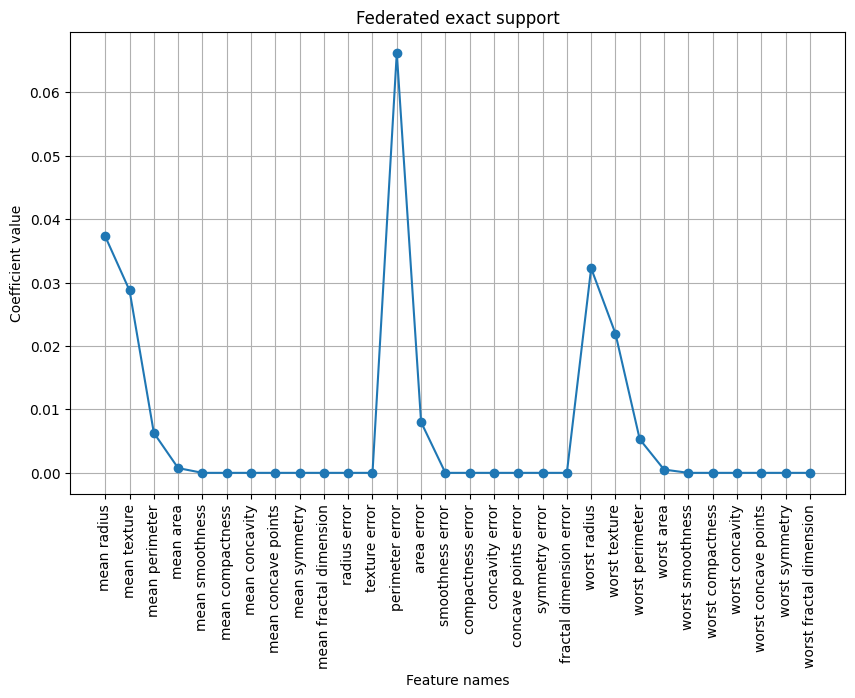

In [ ]:
result0 = fedSgdPar(model=LinearRegressionModel(), T=1, K=10, C=1, E=1, lambd=1)



5
Selected features: ['mean area' 'area error' 'worst texture' 'worst perimeter' 'worst area']
Test MSE: 0.07297446803118426


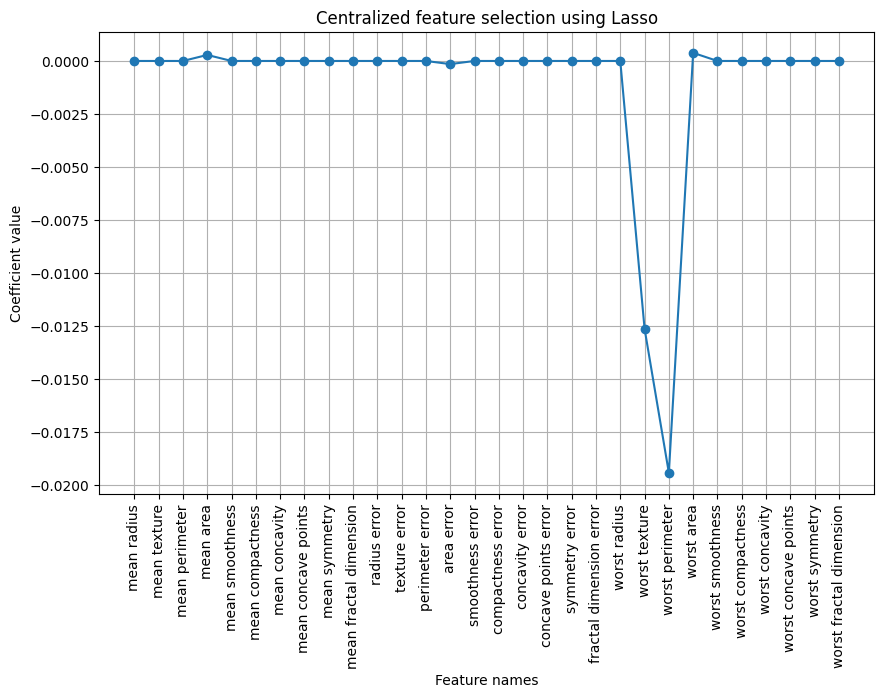

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
import random
import torch

# Set the random seeds
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Load the Breast Cancer dataset
breast_cancer = load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
feature_names = breast_cancer.feature_names

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Train LASSO regression model for feature selection
alpha = 0.1  # Regularization strength
lasso = Lasso(alpha=alpha, max_iter=10000)
lasso.fit(X_train, y_train)

# Print the selected features (non-zero coefficients)
selected_features = np.where(lasso.coef_ != 0)[0]
selected_feature_names = feature_names[selected_features]
print(len(selected_feature_names))
print(f"Selected features: {selected_feature_names}")

# Calculate test MSE
test_mse = np.mean((lasso.predict(X_test) - y_test) ** 2)
print(f"Test MSE: {test_mse}")

# Plot the LASSO coefficients
plt.figure(figsize=(10, 6))
plt.plot(range(X.shape[1]), lasso.coef_, marker='o')
plt.title("Centralized feature selection using Lasso")
plt.xticks(range(X.shape[1]), feature_names, rotation=90)  # Show feature names on the x-axis
plt.xlabel("Feature names")
plt.ylabel("Coefficient value")
plt.grid(True)
plt.show()